#### ANL Sprint 2017

HSC-DR1 LSS Sprint:
Addressing the first task here:
https://github.com/LSSTDESC/HyperSupremeStructure-HSC-LSS/blob/master/SprintWeekDiary.md, that is comparing Depth (limiting magnitude) from different methods. Based on the analysis, know that random sky_std method doesnt work so focus on the other three methods:
1. Using Javi's method
2. Binning 5*flux_error for all galaxies in each pixel.
3. Use the method used in HSC-DR1 paper: 5sigma depth= mean of mag of galaxies with 4<SNR<6

We calculate the 10sigma maps.

##### Need a quantitative comparison of the outputs from the three methods.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import os
from astropy.io import fits

from astropy.table import Table
import healpy as hp
from collections import OrderedDict
from matplotlib import cm
import copy

from dataCleanUp import dataCleanUp
from addSNR import addSNR
from createMaps import createMeanStdMaps
from mpl_toolkits.axes_grid1 import ImageGrid
import rotate as rtt
import flatmaps as fm

import estDepth

Read in the data. Reading the latest ones: now have the random Table for the wide GAMA15H field.

In [77]:
HSCdatapath= '/global/cscratch1/sd/damonge/HSC/'
#HSCFields= ['WIDE_GAMA15H']
HSCFields= ['WIDE_XMMLSS','COSMOS_WIDE_WORST','COSMOS_WIDE_BEST','WIDE_AEGIS'] # now random have is primary

In [78]:
HSCFiles= [HSCdatapath+'HSC_'+f+'_forced.fits' for f in HSCFields]
HSCFiles

['/global/cscratch1/sd/damonge/HSC/HSC_WIDE_XMMLSS_forced.fits',
 '/global/cscratch1/sd/damonge/HSC/HSC_COSMOS_WIDE_WORST_forced.fits',
 '/global/cscratch1/sd/damonge/HSC/HSC_COSMOS_WIDE_BEST_forced.fits',
 '/global/cscratch1/sd/damonge/HSC/HSC_WIDE_AEGIS_forced.fits']

In [79]:
HSCdata= {}
for (filename,field) in zip(HSCFiles,HSCFields):
    key= field
    print key
    dat = Table.read(filename, format='fits')
    HSCdata[key] = dat.to_pandas()
    
#HSCFieldTag= key.split('_')[0]  # just the field tag.

WIDE_XMMLSS
COSMOS_WIDE_WORST
COSMOS_WIDE_BEST
WIDE_AEGIS


In [80]:
# clean up
for key in HSCdata:
    print key
    HSCdata[key]= dataCleanUp(HSCdata[key])

COSMOS_WIDE_WORST
Given size of the dataframe:  (533372, 196)
['object_id_isnull', 'ra_isnull', 'dec_isnull', 'tract_isnull', 'patch_isnull', 'merge_peak_g_isnull', 'merge_peak_r_isnull', 'merge_peak_i_isnull', 'merge_peak_z_isnull', 'merge_peak_y_isnull', 'gcountinputs_isnull', 'rcountinputs_isnull', 'icountinputs_isnull', 'zcountinputs_isnull', 'ycountinputs_isnull', 'iflags_pixel_bright_object_center_isnull', 'iflags_pixel_bright_object_any_isnull', 'iclassification_extendedness_isnull', 'a_g_isnull', 'a_r_isnull', 'a_i_isnull', 'a_z_isnull', 'a_y_isnull', 'gflux_psf_isnull', 'rflux_psf_isnull', 'iflux_psf_isnull', 'zflux_psf_isnull', 'yflux_psf_isnull', 'gflux_psf_err_isnull', 'rflux_psf_err_isnull', 'iflux_psf_err_isnull', 'zflux_psf_err_isnull', 'yflux_psf_err_isnull', 'gflux_psf_flags_isnull', 'rflux_psf_flags_isnull', 'iflux_psf_flags_isnull', 'zflux_psf_flags_isnull', 'yflux_psf_flags_isnull', 'gmag_psf_isnull', 'rmag_psf_isnull', 'imag_psf_isnull', 'zmag_psf_isnull', 'ymag_ps

Dropped 98 isnull columns.
Dropped 281879 rows since they contained nan entries.
Final size of the dataframe:  (599339, 98)

WIDE_XMMLSS
Given size of the dataframe:  (8308926, 196)
['object_id_isnull', 'ra_isnull', 'dec_isnull', 'tract_isnull', 'patch_isnull', 'merge_peak_g_isnull', 'merge_peak_r_isnull', 'merge_peak_i_isnull', 'merge_peak_z_isnull', 'merge_peak_y_isnull', 'gcountinputs_isnull', 'rcountinputs_isnull', 'icountinputs_isnull', 'zcountinputs_isnull', 'ycountinputs_isnull', 'iflags_pixel_bright_object_center_isnull', 'iflags_pixel_bright_object_any_isnull', 'iclassification_extendedness_isnull', 'a_g_isnull', 'a_r_isnull', 'a_i_isnull', 'a_z_isnull', 'a_y_isnull', 'gflux_psf_isnull', 'rflux_psf_isnull', 'iflux_psf_isnull', 'zflux_psf_isnull', 'yflux_psf_isnull', 'gflux_psf_err_isnull', 'rflux_psf_err_isnull', 'iflux_psf_err_isnull', 'zflux_psf_err_isnull', 'yflux_psf_err_isnull', 'gflux_psf_flags_isnull', 'rflux_psf_flags_isnull', 'iflux_psf_flags_isnull', 'zflux_psf_flags

Added the columns. Now plotting the distribution.
Added the columns. Now plotting the distribution.
Added the columns. Now plotting the distribution.
Added the columns. Now plotting the distribution.


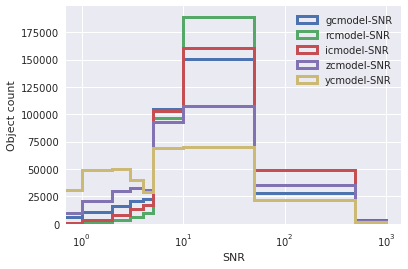

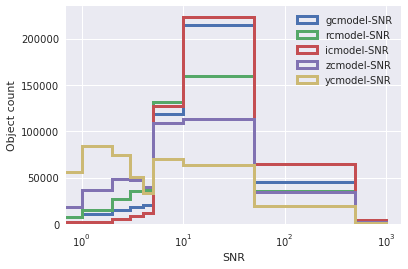

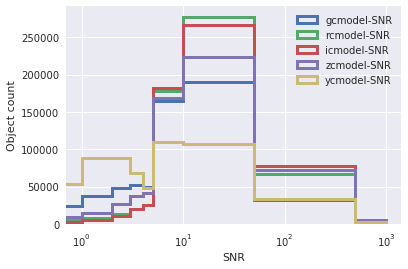

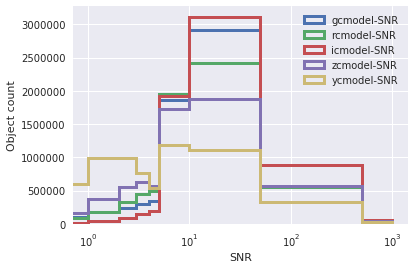

In [81]:
# add SNR columns to the forced catalog.
for key in HSCdata:
    HSCdata[key], SNCols= addSNR(HSCdata[key])

In [83]:
rotations={}
for key in HSCdata :
    print key
    ramean=np.mean(HSCdata[key]['ra'])
    decmean=np.mean(HSCdata[key]['dec'])
    rotations[key],rar,decr=rtt.get_new_coords(HSCdata[key],ramean,decmean)
    HSCdata[key]['ra_r']=rar
    HSCdata[key]['dec_r']=decr
    

COSMOS_WIDE_WORST
WIDE_AEGIS
COSMOS_WIDE_BEST
WIDE_XMMLSS


In [84]:
HSCField= 'WIDE_XMMLSS'
ra_min=np.amin(HSCdata[HSCField]['ra_r'])
ra_max=np.amax(HSCdata[HSCField]['ra_r'])
dec_min=np.amin(HSCdata[HSCField]['dec_r'])
dec_max=np.amax(HSCdata[HSCField]['dec_r'])
ra_range=[ra_min-0.15*(ra_max-ra_min),ra_max+0.15*(ra_max-ra_min)]
dec_range=[dec_min-0.15*(dec_max-dec_min),dec_max+0.15*(dec_max-dec_min)]
flatSkyGrid= fm.FlatMapInfo(ra_range,dec_range, dx=0.03,dy=0.03)
print ra_range,dec_range

[28.385215252178135, 40.703430780013207] [-1.80247650690238, 1.8442397010835663]


### Estimate 10$\sigma$ depth 

In [85]:
bands= ['i']
SNRthreshold= 10
depthMap, depthMap_var= {}, {}
outputDir= 'flatmaps_nside1024/'
saveMaps= False

### Method 1: Javi's

Creating i-band 10sigma depth maps


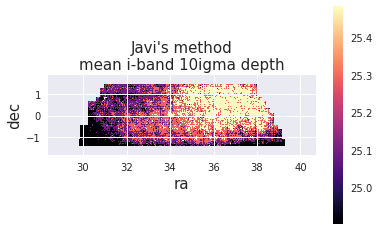

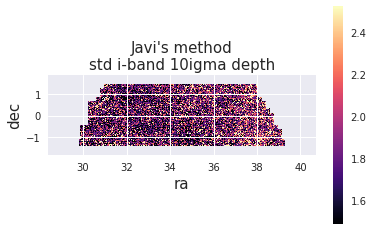

In [86]:
# create the 5sigma depth maps for each filter, using cmodel mags. plot skymaps + cartview.
method= 'Javis'
depthMap[method], depthMap_var[method]= {}, {} 
for band in bands:
    key= '%scmodel'%band
    out= estDepth.desc_method(HSCdata[HSCField]['ra_r'], HSCdata[HSCField]['dec_r'], band,
                              mags= HSCdata[HSCField]['%s_mag'%key],
                              snr= HSCdata[HSCField]['%s-SNR'%key],
                              flatSkyGrid= flatSkyGrid,
                              SNRthreshold= SNRthreshold, plotMaps= True,
                              saveMaps= saveMaps, outputDir= outputDir)    
    depthMap[method][band], depthMap_var[method][band]= out

### Method 2: 
Bin 10*flux_error for all galaxies in each pixel.



Creating i-band 10sigma depth maps


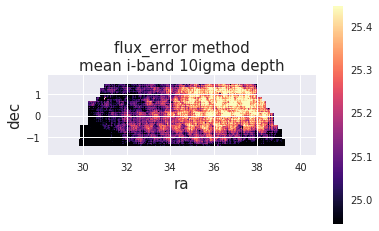

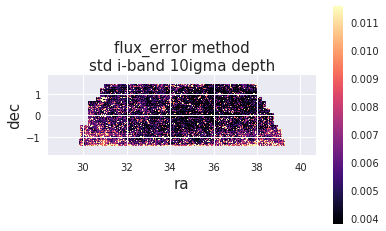

In [87]:
method= 'FluxErr'
depthMap[method], depthMap_var[method]= {}, {} 


for band in bands:
    out= estDepth.flux_err_method(HSCdata[HSCField]['ra_r'], HSCdata[HSCField]['dec_r'],
                                  HSCdata[HSCField]['%scmodel_flux_err'%band],
                                  band, flatSkyGrid, SNRthreshold= SNRthreshold, plotMaps= True,
                                  saveMaps= saveMaps, outputDir= outputDir)
    depthMap[method][band], depthMap_var[method][band]= out

### Method 4

In the paper: 5sigma depth= mean of objs with 4<SNR<6.

So for 10sigma depth= mean of objs with 9<SNR<11.

Creating i-band 10sigma depth maps


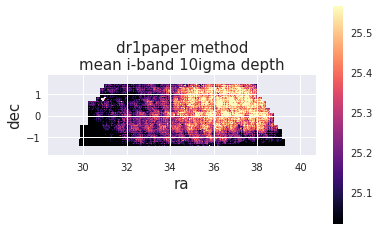

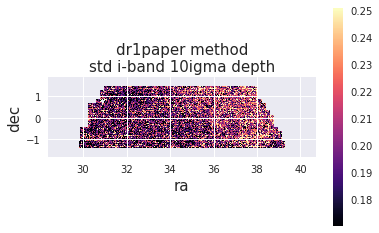

In [88]:
# create the 5sigma depth maps for each filter, using cmodel mags. plot skymaps + cartview.
method= 'dr1paper'
depthMap[method], depthMap_var[method]= {}, {} 
for band in bands:
    key= '%scmodel'%band
    out= estDepth.dr1paper_method(HSCdata[HSCField]['ra_r'], HSCdata[HSCField]['dec_r'], band,
                                  mags= HSCdata[HSCField]['%s_mag'%key],
                                  snr= HSCdata[HSCField]['%s-SNR'%key],
                                  flatSkyGrid= flatSkyGrid,
                                  SNRthreshold= SNRthreshold, plotMaps= True,
                                  saveMaps= saveMaps, outputDir= outputDir)    
    depthMap[method][band], depthMap_var[method][band]= out

### Comparison

In [89]:
cmap = cm.magma

/global/common/cori/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


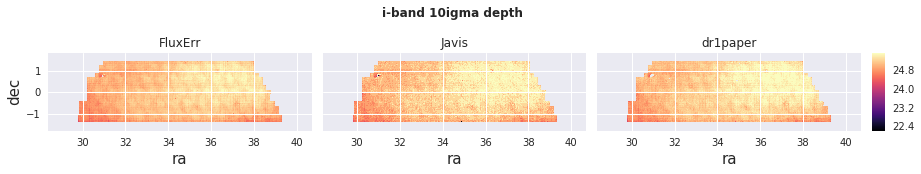

/global/common/cori/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater


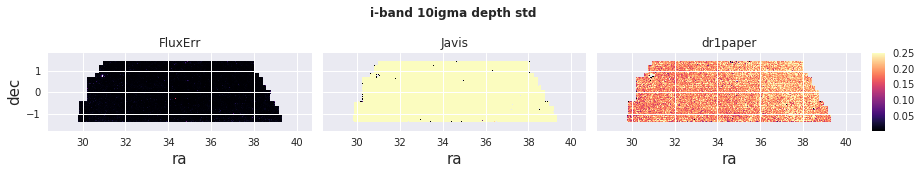

In [90]:
xlabel, ylabel= 'ra', 'dec'
nCols= len(depthMap.keys())
for band in bands:
    # plot the depth for each method.
    fig = plt.figure(figsize=(15, 10))
    # set up for colorbar
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1, nCols), axes_pad=0.15, share_all= True, cbar_location="right",
                     cbar_mode="single", cbar_size="5%", cbar_pad=0.15,
                     )
    # since have three maps, need colorange that ~works for all.
    colorMin= 100
    colorMax= -100
    for mInd, method in enumerate(depthMap):
        ind= np.where(depthMap[method][band]>0)[0]
        colorMin= min(colorMin, np.percentile(depthMap[method][band][ind], 0))
        colorMax= max(colorMax, np.percentile(depthMap[method][band][ind], 95))
    # plot
    for mInd, method in enumerate(depthMap):
        ax= grid[mInd]
        image= ax.imshow(depthMap[method][band].reshape([flatSkyGrid.ny,flatSkyGrid.nx]),
                         origin='lower', interpolation='nearest',
                         aspect='equal', extent=[flatSkyGrid.x0, flatSkyGrid.xf, flatSkyGrid.y0, flatSkyGrid.yf],
                         vmin= colorMin, vmax= colorMax, cmap= cmap)
        ax.set_title(method)
        ax.set_xlabel(xlabel,fontsize=15)
        ax.set_ylabel(ylabel,fontsize=15)
        ax.cax.colorbar(image)
        ax.cax.toggle_label(True)
    plt.suptitle('%s-band %sigma depth'%(band, SNRthreshold), fontweight="bold", )
    plt.subplots_adjust(top=1.6)
    plt.show()
    
    # plot std similar to depth plots above.
    fig = plt.figure(figsize=(15, 10))
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1, nCols), axes_pad=0.15, share_all= True, cbar_location="right",
                     cbar_mode="single", cbar_size="5%", cbar_pad=0.15,
                     )
    colorMin= 100
    colorMax= -100
    for mInd, method in enumerate(depthMap):
            ind= np.where(depthMap_var[method][band]>0)[0]
            colorMin= min(colorMin, np.percentile(depthMap_var[method][band][ind], 0))
            colorMax= max(colorMin, np.percentile(depthMap_var[method][band][ind], 95))
            
    for mInd, method in enumerate(depthMap):
        ax= grid[mInd]
        image= ax.imshow(depthMap_var[method][band].reshape([flatSkyGrid.ny,flatSkyGrid.nx]),
                         origin='lower', interpolation='nearest',
                         aspect='equal', extent=[flatSkyGrid.x0, flatSkyGrid.xf, flatSkyGrid.y0, flatSkyGrid.yf],
                         vmin= colorMin, vmax= colorMax, cmap= cmap)
        ax.set_title(method)
        ax.set_xlabel(xlabel,fontsize=15)
        ax.set_ylabel(ylabel,fontsize=15)
        ax.cax.colorbar(image)
        ax.cax.toggle_label(True)
    plt.suptitle('%s-band %sigma depth std'%(band, SNRthreshold), fontweight="bold", )
    plt.subplots_adjust(top=1.6)
    plt.show()

#### Ok so the overall structure looks comparable; not much has changed as compared to 5sigma depth maps. dr1paper method gives depth std that is lower than Javi's (expected since it looks at a range of SNR); fluxErr std is very small.